<a href="https://colab.research.google.com/github/seidmutant/retention-analysis/blob/main/retention_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# @title Google Collab Notebook
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'PROJECT_ID_HERE' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

In [10]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Job ID inserted based on the query results selected to explore
job_id = 'JOB_ID_HERE'


In [12]:
# Running this code will display the query used to generate your previous job
job = client.get_job(job_id)
print(job.query)

WITH transactions AS (
  SELECT from_address, DATE(block_timestamp) AS created_at
  FROM `bigquery-public-data.crypto_ethereum.transactions`
),

cohort AS (
  SELECT 
    from_address,
    MIN(
      CAST(FORMAT_DATETIME('%Y-%m', PARSE_DATETIME('%Y-%m-%d', CAST(DATE(created_at) AS STRING))) || '-01' AS DATE)
    ) AS cohort_month
  FROM transactions
  GROUP BY 1
),

cohort_size AS (
  SELECT
    cohort_month,
    COUNT(1) as num_users
  FROM cohort
  GROUP BY cohort_month
),

user_activities AS (
  SELECT
    DISTINCT
      DATE_DIFF(
        EXTRACT(DATE FROM TIMESTAMP(created_at)),
        cohort_month,
        MONTH
      ) as month_number,
      A.from_address
  FROM transactions AS A
  LEFT JOIN cohort AS C 
  ON A.from_address = C.from_address
),

retention_table AS (
  SELECT
    cohort_month,
    A.month_number,
    COUNT(1) AS num_users
  FROM user_activities A
  LEFT JOIN cohort AS C 
  ON A.from_address = C.from_address
  GROUP BY 1, 2  
)

SELECT
  A.cohort_month,
  B.num_u

In [13]:
# Tranform results to a dataframe
results = job.to_dataframe()
results.head()

,cohort_month,total_users,month_number,percentage
0,2022-01-01,2646796,0,100.00
1,2022-01-01,2646796,1,22.49
2,2022-01-01,2646796,2,22.73
3,2022-01-01,2646796,3,11.26
4,2022-01-01,2646796,4,11.79


In [14]:
# Pivot data
results_pivot = pd.pivot_table(results, values='percentage', index=['cohort_month'], columns=['month_number'], aggfunc=np.sum)
results_pivot.head()

month_number,0,1,2,3,4,5,6,7,8,9,10
cohort_month,,,,,,,,,,,
2022-01-01,100.0,22.49,22.73,11.26,11.79,6.55,10.21,8.63,8.00,4.79,2.75
2022-02-01,100.0,20.72,12.18,12.39,7.85,12.90,10.70,8.37,4.85,2.76,NaN
2022-03-01,100.0,12.80,9.31,6.30,9.96,9.35,8.91,4.59,2.67,NaN,NaN
2022-04-01,100.0,17.25,9.56,13.02,12.26,10.69,6.07,3.23,NaN,NaN,NaN
2022-05-01,100.0,12.92,13.43,10.78,9.63,5.92,3.55,NaN,NaN,NaN,NaN


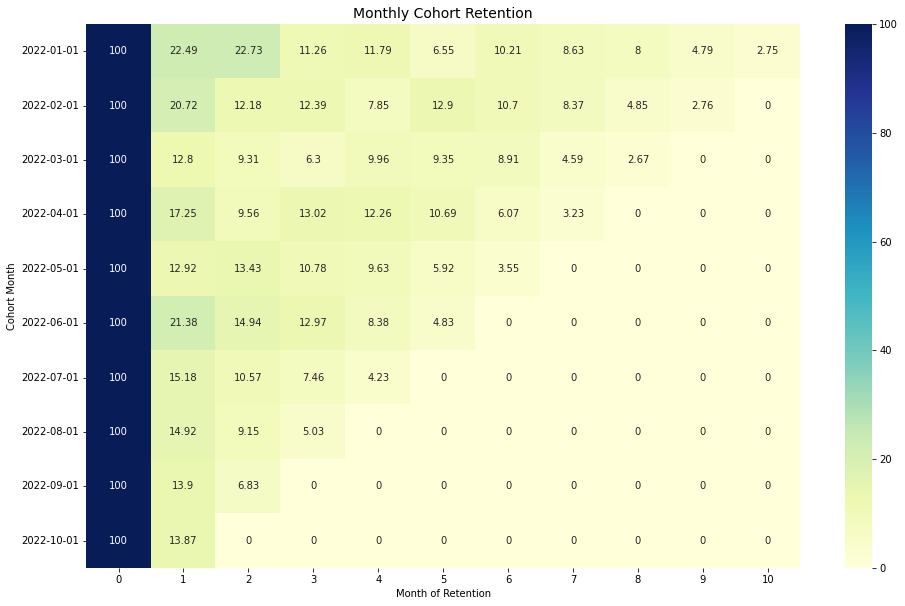

In [15]:
# Initialize the figure
plt.figure(figsize=(16, 10))

# Add a title
plt.title('Monthly Cohort Retention', fontsize = 14)

# Creating the heatmap
sns.heatmap(results_pivot.fillna(0), annot = True,vmin = 0.0, vmax =100, cmap="YlGnBu", fmt='g')

# Labels and axis
plt.ylabel('Cohort Month')
plt.xlabel('Month of Retention')
plt.yticks(rotation='360')

# Display plot
plt.show()